In [1]:
import nbpresent
%matplotlib inline
from __future__ import division, print_function
from unscentedtransform import *

# What is the Unscented Transform?

## Ryan Dwyer 2016.09.16

# Outline

- Unscented transform
- Unscented Kalman filter

# Detailed outline

- Unscented transform
    - Non-linear transformations
    - Canonical example is Cartesian to polar coordinates
    - How do you transform error bars?
    - Standard way is to linearize (this is also the rule used in standard error propogation limits)
    - Show how this fails causes problems in non-linear applications, especially when the error bars get large!
    - Linearization would say no information here, which can cause problems.
    - Systems can become very brittle in the presense of large errors, since the errors are always propogated linearly.
    - Idea: take well-chosen points, put them through the full non-linear transformation, and then make a much better approximation!
    - Show linearized error, show unscented transform error.
- Unscented Kalman filter

## What problem does the unscented transform address? 
### Difficult to transform a propability distribution through a non-linear transformation

# Propogation of uncertainty

- Typical time scientists deal with this problem
- Usual solution?
    - Approximate probability distributions with Gaussians
    - Assume errors small, linearize near the mean value

## Example
- Determine error in $x$ from error in $A$, $\phi$.
  $$x = A \cos \phi$$
- Normal method: *Linearize!*
  $$\begin{align}
  \bar{x} + \delta x&  = (\bar{A} + \delta A) \cos (\bar{\phi} + \delta \phi) \\
  \bar{x}& = \bar{A} \cos \bar{\phi} \\
  \sigma_x^2& = \sigma_A^2 \cos^2 \bar{\phi} + \sigma_\phi^2 (\bar{A} \sin \bar{\phi})^2 
  \end{align}$$

# Linearized error

Consider a non-linear transformation:
$$y = f(x)$$
- $x$ distributed with mean $\bar{x}$, variance $\sigma^2_x$.
- Linear approximation: assume errors small compared to the mean
    $$\begin{align}
    \bar{y}& = f(\bar{x}) \\
    \sigma_y^2& = \sigma^2_x \left. \left (\frac{\partial f}{\partial x} \right )^2 \right |_{x = \bar{x}} \\
    \quad &
    \end{align}
    $$
- This is how textbook propagation of uncertainty is derived (addition: add variances, multiplication: add relative variables, etc)

# Linearized error: vectors

- With vectors, we need to use the Jacobian matrix to approximate the covariance $P$:
$$
\begin{align}
J = \begin{pmatrix}
\frac{\partial f_1}{\partial x_1} & \frac{\partial f_1}{\
\partial x_2}& \cdots \\
\frac{\partial f_2}{\partial x_1} & \frac{\partial f_2}{\
\partial x_2} \\
\vdots & & \ddots 
\end{pmatrix}
\end{align}
$$

# Linearized error: vectors

- Then,

$$\begin{align}
    \bar{\mathbf{y}}& = f(\bar{\mathbf{x}}) \\
    P_y& = J P_x J^T 
    \end{align}
$$

- Note: Need to evaluate $N^2$ derivatives!

# Linearized error: example

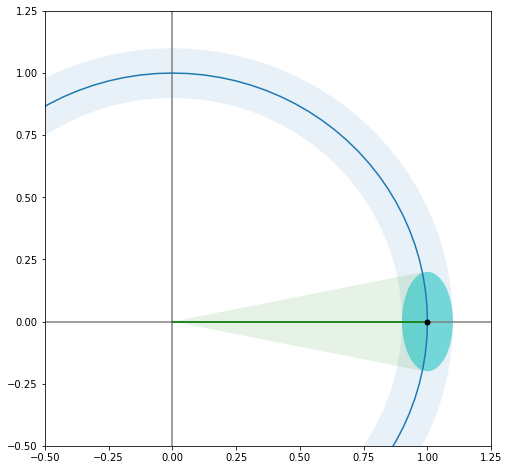

In [2]:
ipy.interact(magtime_phi_linear,
             mu_phi=ipy.FloatSlider(value=0.0, min=0.0, max=np.pi/2, step=0.1, description=r'$\mu_\phi$'),
             sigma_A=ipy.FloatSlider(value=0.1, min=0.01, max=0.2, step=0.01, description=r'$\sigma_A$'),
             sigma_phi=ipy.FloatSlider(value=0.2, min=0.01, max=np.pi/4, step=0.01, description=r'$\sigma_\phi$')
            );

- Approximating error as Gaussian: shape must be elliptical
- Linear approximation geometrically intuitive
- What problems arise with a linear approximation?

# Sample error

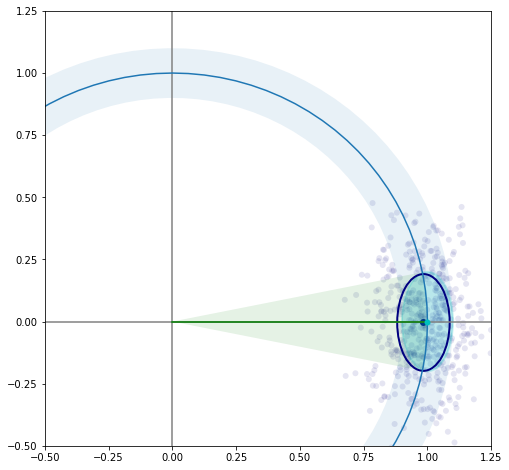

In [3]:
ipy.interact(magtime_phi_exact,
             mu_phi=ipy.FloatSlider(value=0.0, min=0.0, max=np.pi/2, step=0.1, description=r'$\mu_\phi$'),
             sigma_A=ipy.FloatSlider(value=0.1, min=0.01, max=0.2, step=0.01, description=r'$\sigma_A$'),
             sigma_phi=ipy.FloatSlider(value=0.2, min=0.01, max=np.pi/4, step=0.01, description=r'$\sigma_\phi$'),
             xlim=ipy.FloatRangeSlider(value=(-0.5, 1.25), min=-1, max=1.5, step=0.05),
             ylim=ipy.FloatRangeSlider(value=(-0.5, 1.25), min=-1, max=1.5, step=0.05));

- Blue points are samples.
- Blue oval is the approximation by calculating the mean, covariance from $N = 500$ samples of the distribution.

- Random sample approximates the mean, standard deviation well,
  but is computationally intensity.
- Same benefits with many fewer points?
- Yes, *unscented transform!*

# Unscented transform: key ideas

1. Easy to perform a nonlinear transformation on a single point
2. Pretty easy to pick a few points so that the mean, covariance well-approximate the best approximate gaussian mean, covariance.

# Unscented transform

- Consider,

    $$y = f(x)$$
    

- $x$ distributed with mean $\mu_x$, covariance $\sigma^2_x$.
- Approximate mean $\mu_y$, covariance $\sigma^2_y$ using small number of well-chosen points $X$.

## Recipe

1. Generate a vector of sample points. A good default choice is points of the form
   $$\mu_x \pm (\sqrt{\sigma_x^2})_i$$
2. Apply non-linear transformation to $X$.
   $$Y = f(X)$$
3. Approximate the mean:
   $$\mu_y \approx \bar{Y}$$
4. Approximate the covariance:
   $$P_y  \approx ( Y - \bar{Y}) ( Y - \bar{Y})^T$$

# Unscented transform

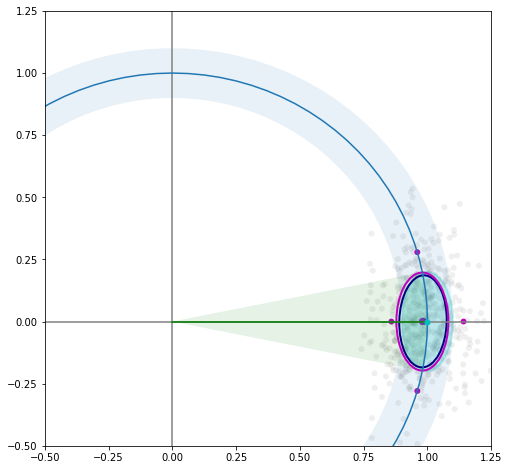

In [4]:
ipy.interact(magtime_phi_unscented,
             mu_phi=ipy.FloatSlider(value=0.0, min=0.0, max=np.pi/2, step=0.1, description=r'$\mu_\phi$'),
             sigma_A=ipy.FloatSlider(value=0.1, min=0.01, max=0.2, step=0.01, description=r'$\sigma_A$'),
             sigma_phi=ipy.FloatSlider(value=0.2, min=0.01, max=np.pi/4, step=0.01, description=r'$\sigma_\phi$'),
             xlim=ipy.FloatRangeSlider(value=(-0.5, 1.25), min=-1, max=1.5, step=0.05),
             ylim=ipy.FloatRangeSlider(value=(-0.5, 1.25), min=-1, max=1.5, step=0.05));

- Unscented transform sample points, approximate covariance, mean in purple.
- Much better approximation for large errors, dramatically reduced systematic errors.
- Unscented transform good to 2nd or 3rd order (vs. 1st for linearization)
- Don't need to calculate $N

# Unscented Kalman filter

- State vector $\mathbf{x}$: (position, velocity, *and* oscillator frequency, quality factor, surface potential...)
- Deterministic inputs $\mathbf{u}$: Tip voltage, etc.


$$\begin{align}
\dot{\mathbf{x}} & = f(\mathbf{x}, \mathbf{u}, t) \\
\mathbf{y} & = h(\mathbf{x}, \mathbf{u}, t) \\
\end{align}
$$